In [ ]:
import joblib
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from nltk.sentiment import SentimentIntensityAnalyzer
from preprocessing import Preprocessing
import nest_asyncio
import asyncio
from IPython.display import display

nest_asyncio.apply()

svm_model = joblib.load("best_svm_hybrid.pkl")
vectorizer = joblib.load("tfidf_vectorizer_hybrid.pkl")

analyzer = SentimentIntensityAnalyzer()
preprocessing_instance = Preprocessing()

rating_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

def extract_lexicon_features(text):
    scores = analyzer.polarity_scores(text)
    return np.array([[scores["neg"], scores["neu"], scores["pos"], scores["compound"]]])

def predict_single(cleaned_text):
    input_tfidf = vectorizer.transform([cleaned_text])
    input_lexicon = extract_lexicon_features(cleaned_text)
    input_combined = hstack([input_tfidf, input_lexicon])
    prediction = svm_model.predict(input_combined)
    return rating_map[prediction[0]]

async def predict_from_file_with_actual(file_path):
    df = pd.read_csv(file_path)

    cleaned_texts = await asyncio.gather(
        *(preprocessing_instance.preprocessing_pipeline(t) for t in df['text'].astype(str))
    )
    df['text'] = cleaned_texts

    df['Sentiment_Text'] = df['Sentiment_Text'].map(rating_map)

    df['Predicted_Sentiment_Text'] = [predict_single(t) for t in cleaned_texts]

    display(df[['text', 'Sentiment_Text', 'Predicted_Sentiment_Text']])
    return df[['text', 'Sentiment_Text', 'Predicted_Sentiment_Text']]

df_result = await predict_from_file_with_actual("data/testing/testing_dataset.csv")


,text,Sentiment_Text,Predicted_Sentiment_Text
0,walao shop damn expensive lah !,Negative,Negative
1,bro go nasi lemak place !,Neutral,Neutral
2,aiyo blur one,Negative,Neutral
3,movie damn syok must watch !,Positive,Negative
4,borrow charger ah,Neutral,Neutral
...,...,...,...
64,nan,Neutral,Neutral
65,hm i disappointed little delivery rather slow ...,Negative,Negative
66,ask dark blue mild mild check next time,Negative,Neutral
67,too much foreigign yarn too big long thread lo...,Negative,Neutral


In [8]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_result['Sentiment_Text'], df_result['Predicted_Sentiment_Text'], labels=["Negative", "Neutral", "Positive"])
print("Confusion Matrix:\n", cm)
print("Classification Report:")
print(classification_report(df_result['Sentiment_Text'], df_result['Predicted_Sentiment_Text'], target_names=["Negative", "Neutral", "Positive"]))

Confusion Matrix:
 [[ 9 15  0]
 [ 4 12  1]
 [ 5  7 16]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.38      0.43        24
     Neutral       0.35      0.71      0.47        17
    Positive       0.94      0.57      0.71        28

    accuracy                           0.54        69
   macro avg       0.60      0.55      0.54        69
weighted avg       0.64      0.54      0.55        69



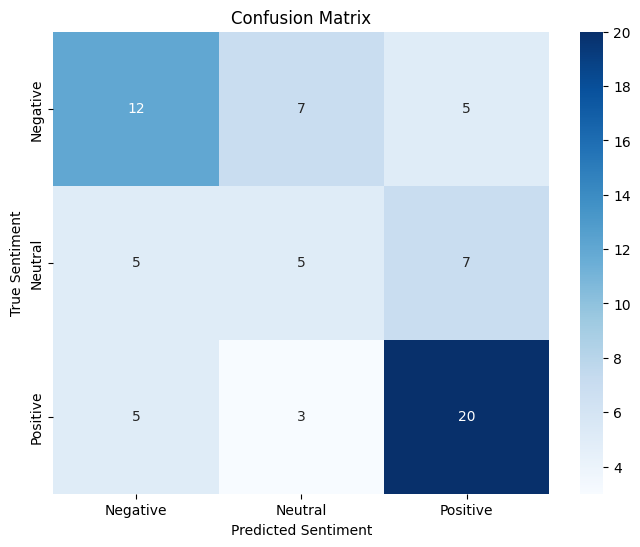

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.show()